In [1]:
"""Evaluation metric for Santa 2024."""

import gc
import os
from math import exp
from collections import Counter
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import transformers
import torch

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    model_path: str = '/kaggle/input/gemma-2/transformers/gemma-2-9b/2',
    load_in_8bit: bool = False,
    clear_mem: bool = False,
) -> float:
    """
    Calculates the mean perplexity of submitted text permutations compared to an original text.

    Parameters
    ----------
    solution : DataFrame
        DataFrame containing the original text in a column named 'text'.
        Includes a row ID column specified by `row_id_column_name`.

    submission : DataFrame
        DataFrame containing the permuted text in a column named 'text'.
        Must have the same row IDs as the solution.
        Includes a row ID column specified by `row_id_column_name`.

    row_id_column_name : str
        Name of the column containing row IDs.
        Ensures aligned comparison between solution and submission.

    model_path : str, default='/kaggle/input/gemma-2/transformers/gemma-2-9b/2'
        Path to the serialized LLM.

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    clear_mem : bool, default=False
        Clear GPU memory after scoring by clearing the CUDA cache.
        Useful for testing.

    Returns
    -------
    float
        The mean perplexity score. Lower is better.

    Raises
    ------
    ParticipantVisibleError
        If the submission format is invalid or submitted strings are not valid permutations.

    Examples
    --------
    >>> import pandas as pd
    >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["this is a normal english sentence", "the quick brown fox jumps over the lazy dog"]
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["sentence english normal a is this", "lazy the over jumps fox brown quick the dog"]
    ... })
    >>> score(solution, submission, 'id', model_path=model_path, clear_mem=True) > 0
    True
    """
    # Check that each submitted string is a permutation of the solution string
    sol_counts = solution.loc[:, 'text'].str.split().apply(Counter)
    sub_counts = submission.loc[:, 'text'].str.split().apply(Counter)
    invalid_mask = sol_counts != sub_counts
    if invalid_mask.any():
        raise ParticipantVisibleError(
            'At least one submitted string is not a valid permutation of the solution string.'
        )

    # Calculate perplexity for the submitted strings
    sub_strings = [
        ' '.join(s.split()) for s in submission['text'].tolist()
    ]  # Split and rejoin to normalize whitespace
    scorer = PerplexityCalculator(
        model_path=model_path,
        load_in_8bit=load_in_8bit,
    )  # Initialize the perplexity calculator with a pre-trained model
    perplexities = scorer.get_perplexity(
        sub_strings
    )  # Calculate perplexity for each submitted string

    if clear_mem:
        # Just move on if it fails. Not essential if we have the score.
        try:
            scorer.clear_gpu_memory()
        except:
            print('GPU memory clearing failed.')

    return float(np.mean(perplexities))


class PerplexityCalculator:
    """
    Calculates perplexity of text using a pre-trained language model.

    Adapted from https://github.com/asahi417/lmppl/blob/main/lmppl/ppl_recurrent_lm.py

    Parameters
    ----------
    model_path : str
        Path to the pre-trained language model

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    device_map : str, default="auto"
        Device mapping for the model.
    """

    def __init__(
        self,
        model_path: str,
        load_in_8bit: bool = False,
        device_map: str = 'auto',
    ):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)
        # Configure model loading based on quantization setting and device availability
        if load_in_8bit:
            if DEVICE.type != 'cuda':
                raise ValueError('8-bit quantization requires CUDA device')
            quantization_config = transformers.BitsAndBytesConfig(load_in_8bit=True)
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                quantization_config=quantization_config,
                device_map=device_map,
            )
        else:
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
                device_map=device_map,
            )

        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')

        self.model.eval()

    def get_perplexity(
        self, input_texts: Union[str, List[str]], debug=False
    ) -> Union[float, List[float]]:
        """
        Calculates the perplexity of given texts.

        Parameters
        ----------
        input_texts : str or list of str
            A single string or a list of strings.

        batch_size : int, default=None
            Batch size for processing. Defaults to the number of input texts.

        debug : bool, default=False
            Print debugging information.

        Returns
        -------
        float or list of float
            A single perplexity value if input is a single string,
            or a list of perplexity values if input is a list of strings.

        Examples
        --------
        >>> import pandas as pd
        >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
        >>> scorer = PerplexityCalculator(model_path=model_path)

        >>> submission = pd.DataFrame({
        ...     'id': [0, 1, 2],
        ...     'text': ["this is a normal english sentence", "thsi is a slihgtly misspelled zr4g sentense", "the quick brown fox jumps over the lazy dog"]
        ... })
        >>> perplexities = scorer.get_perplexity(submission["text"].tolist())
        >>> perplexities[0] < perplexities[1]
        True
        >>> perplexities[2] < perplexities[0]
        True

        >>> perplexities = scorer.get_perplexity(["this is a sentence", "another sentence"])
        >>> all(p > 0 for p in perplexities)
        True

        >>> scorer.clear_gpu_memory()
        """
        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts

        loss_list = []
        with torch.no_grad():
            # Process each sequence independently
            for text in input_texts:
                # Explicitly add sequence boundary tokens to the text
                text_with_special = f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}"

                # Tokenize
                model_inputs = self.tokenizer(
                    text_with_special,
                    return_tensors='pt',
                    add_special_tokens=False,
                )

                if 'token_type_ids' in model_inputs:
                    model_inputs.pop('token_type_ids')

                model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

                # Get model output
                output = self.model(**model_inputs, use_cache=False)
                logits = output['logits']

                # Shift logits and labels for calculating loss
                shift_logits = logits[..., :-1, :].contiguous()  # Drop last prediction
                shift_labels = model_inputs['input_ids'][..., 1:].contiguous()  # Drop first input

                # Calculate token-wise loss
                loss = self.loss_fct(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1)
                )

                # Calculate average loss
                sequence_loss = loss.sum() / len(loss)
                loss_list.append(sequence_loss.cpu().item())

                # Debug output
                if debug:
                    print(f"\nProcessing: '{text}'")
                    print(f"With special tokens: '{text_with_special}'")
                    print(f"Input tokens: {model_inputs['input_ids'][0].tolist()}")
                    print(f"Target tokens: {shift_labels[0].tolist()}")
                    print(f"Input decoded: {self.tokenizer.decode(model_inputs['input_ids'][0])}")
                    print(f"Target decoded: {self.tokenizer.decode(shift_labels[0])}")
                    print(f"Individual losses: {loss.tolist()}")
                    print(f"Average loss: {sequence_loss.item():.4f}")

        ppl = [exp(i) for i in loss_list]

        if debug:
            print("\nFinal perplexities:")
            for text, perp in zip(input_texts, ppl):
                print(f"Text: '{text}'")
                print(f"Perplexity: {perp:.2f}")

        return ppl[0] if single_input else ppl

    def clear_gpu_memory(self) -> None:
        """Clears GPU memory by deleting references and emptying caches."""
        if not torch.cuda.is_available():
            return

        # Delete model and tokenizer if they exist
        if hasattr(self, 'model'):
            del self.model
        if hasattr(self, 'tokenizer'):
            del self.tokenizer

        # Run garbage collection
        gc.collect()

        # Clear CUDA cache and reset memory stats
        with DEVICE:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            torch.cuda.reset_peak_memory_stats()

In [2]:
# initialize scorer
scorer = PerplexityCalculator('/kaggle/input/gemma-2/transformers/gemma-2-9b/2')

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
import random

class GeneticAlgorithm:
    def __init__(self, random_state, population_size, generations, mutation_rate, elite_rate):
        random.seed(random_state)
        self.population_size = population_size  
        self.generations = generations         
        self.mutation_rate = mutation_rate     
        self.elite_rate = elite_rate            
    
    def order_crossover(self, parent1, parent2):
        """
        Order Crossover: OX
        """
        # randomly select 2 points
        start, end = sorted(random.sample(range(len(parent1)), 2))
        
        # copy words between two points of parent 1
        child = [None] * len(parent1)
        child[start:end+1] = parent1[start:end+1]
        
        # complete the remaining words from parent 2
        remaining = parent2.copy()
        for used_word in child:
            if used_word is not None:
                remaining.remove(used_word)

        j = 0
        for i in range(len(child)):
            if child[i] is None:
                child[i] = remaining[j]
                j += 1
        
        return child
    
    def mutate(self, individual):
        """
        Mutation of individuals by swapping
        """
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(individual)), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual
    
    def solve(self, text):
        words = text.split()
        word_N = len(words)

        # generate init solutions
        population = [random.sample(words, word_N) for _ in range(self.population_size)]
        
        # log
        log_energies = []
        
        for generation in range(self.generations):
            # eval fitness
            fitness_scores = [scorer.get_perplexity(' '.join(ind)) for ind in population]

            # log
            log_energies.append(min(fitness_scores))
            
            # choice elites
            elite_indices = sorted(range(len(fitness_scores)), 
                                   key=lambda k: fitness_scores[k])[:int(self.population_size * self.elite_rate)]
            new_population = [population[i] for i in elite_indices]
            
            # crossover and mutate
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(population, 2)
                child = self.order_crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)
            
            population = new_population
        
        # choice best individual
        fitness_scores = [scorer.get_perplexity(' '.join(ind)) for ind in population]
        best_individual = population[np.argmin(fitness_scores)]
        best_energy = min(fitness_scores)
        
        return ' '.join(best_individual), best_energy, log_energies

In [4]:
params = {
    'random_state': 42,
    'population_size': 30,  
    'generations': 100,    
    'mutation_rate': 0.2,  
    'elite_rate': 0.2,     
}
optimizer = GeneticAlgorithm(**params)

In [5]:
sample_submission = pd.read_csv('/kaggle/input/santa-2024/sample_submission.csv')
text = sample_submission.loc[0, 'text']
solution, score, log_scores = optimizer.solve(text)

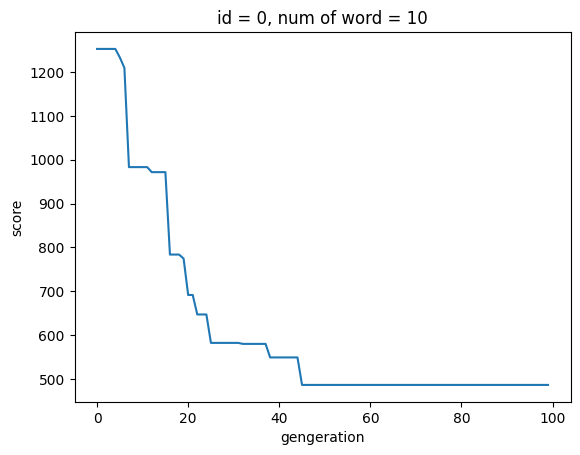

In [6]:
import matplotlib.pyplot as plt
plt.plot(log_scores)
plt.title(f'id = 0, num of word = {len(text.split())}')
plt.xlabel('gengeration')
plt.ylabel('score')
plt.show()

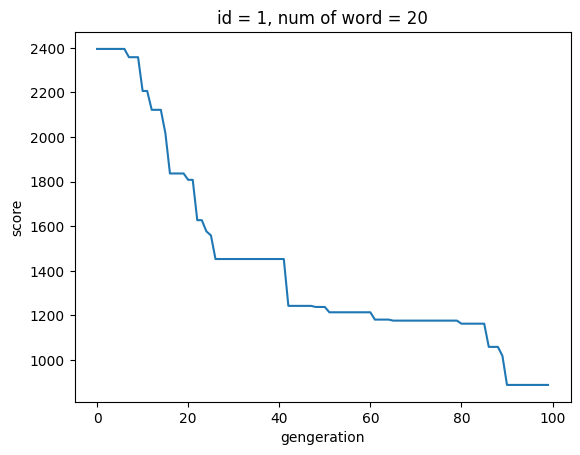

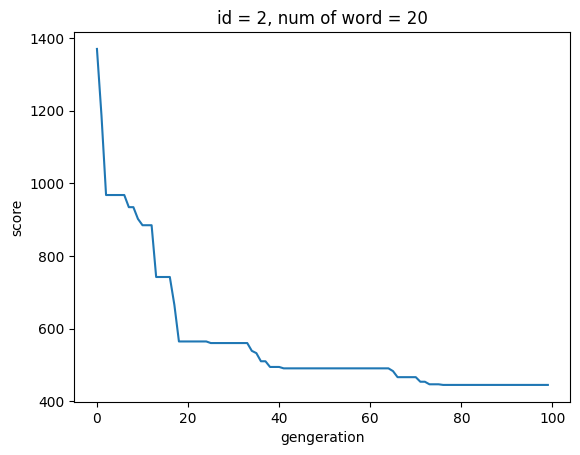

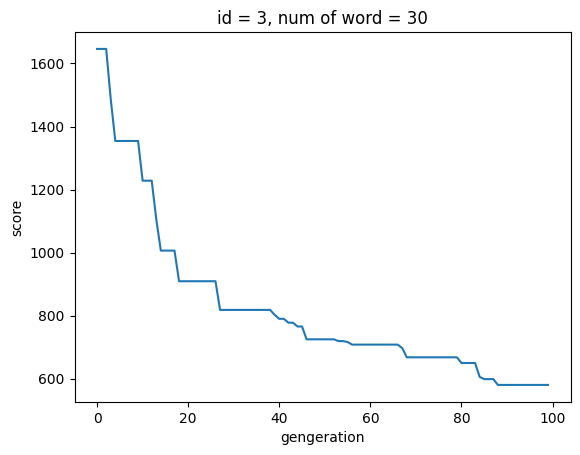

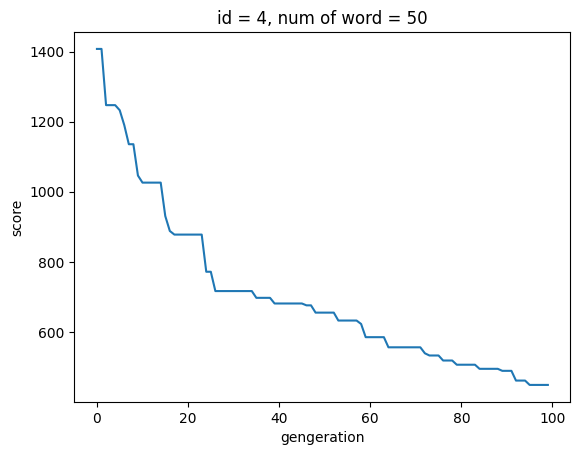

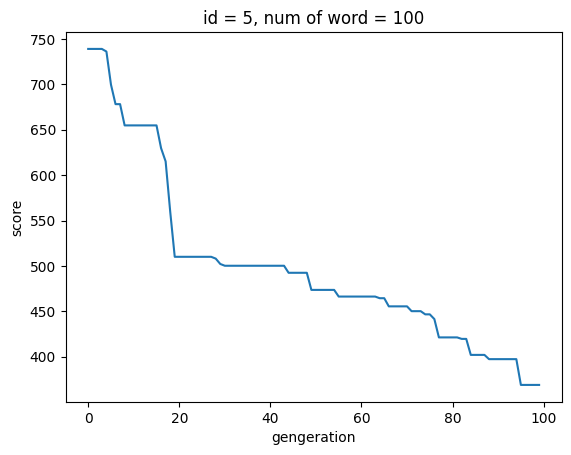

In [7]:
solutions = [solution]
scores = [score]
for i in range(1,6):
    text = sample_submission.loc[i, 'text']
    solution, score, log_scores = optimizer.solve(text)
    solutions.append(solution)
    scores.append(score)
    plt.plot(log_scores)
    plt.title(f'id = {i}, num of word = {len(text.split())}')
    plt.xlabel('gengeration')
    plt.ylabel('score')
    plt.show()

sample_submission['GA_text'] = solutions
sample_submission['GA_score'] = scores
sample_submission['GA_eval_count'] = params['generations'] * params['population_size']
sample_submission.to_csv('GA.csv', index=False)

In [8]:
pd.options.display.max_colwidth=10000
sample_submission[['GA_text', 'GA_score', 'GA_eval_count']]

,GA_text,GA_score,GA_eval_count
0,reindeer mistletoe elf gingerbread ornament family advent scrooge chimney fireplace,486.628014,3000
1,gingerbread ornament advent family bake walk jump sleep the night drive give laugh reindeer and elf scrooge mistletoe chimney fireplace,888.080596,3000
2,jingle yuletide holiday cheer nutcracker magi grinch gifts stocking ornament decorations holly naughty nice chimney carol sleigh polar beard workshop,444.814015,3000
3,jingle yuletide and magi relax unwrap stocking the chimney of holly eat grinch nutcracker polar carol sing naughty is nice visit sleigh beard workshop holiday cheer decorations ornament gifts cheer,580.146844,3000
4,peppermint game cookie it milk night have joy you wish not hope we merry season chocolate star the candle peace in candy as kaggle toy doll to with wonder workshop puzzle eggnog dream of wreath angel fruitcake snowglobe bow and wrapping paper from greeting card poinsettia believe that fireplace hohoho,448.302734,3000
5,sleigh grinch that it walk not hope nutcracker naughty unwrap sing joy fruitcake candy from nice to peace with elf is laugh as hohoho you eat in angel chocolate cookie sleep peppermint poinsettia doll jump visit reindeer advent stocking toy polar bake believe snowglobe wonder merry gifts kaggle milk candle star dream puzzle game season relax magi bow decorations carol paper eggnog beard mistletoe drive have wish wrapping we scrooge gingerbread wreath holiday cheer and the night workshop fireplace cheer and the of chimney night workshop yuletide fireplace holly give jingle ornament greeting ornament card family and the of chimney,368.763770,3000


In [9]:
sub = sample_submission.copy()
sub = sub[['id','GA_text']]
sub = sub.rename(columns={'GA_text':'text'})
sub.to_csv('submission.csv', index=False)
sub

,id,text
0,0,reindeer mistletoe elf gingerbread ornament family advent scrooge chimney fireplace
1,1,gingerbread ornament advent family bake walk jump sleep the night drive give laugh reindeer and elf scrooge mistletoe chimney fireplace
2,2,jingle yuletide holiday cheer nutcracker magi grinch gifts stocking ornament decorations holly naughty nice chimney carol sleigh polar beard workshop
3,3,jingle yuletide and magi relax unwrap stocking the chimney of holly eat grinch nutcracker polar carol sing naughty is nice visit sleigh beard workshop holiday cheer decorations ornament gifts cheer
4,4,peppermint game cookie it milk night have joy you wish not hope we merry season chocolate star the candle peace in candy as kaggle toy doll to with wonder workshop puzzle eggnog dream of wreath angel fruitcake snowglobe bow and wrapping paper from greeting card poinsettia believe that fireplace hohoho
5,5,sleigh grinch that it walk not hope nutcracker naughty unwrap sing joy fruitcake candy from nice to peace with elf is laugh as hohoho you eat in angel chocolate cookie sleep peppermint poinsettia doll jump visit reindeer advent stocking toy polar bake believe snowglobe wonder merry gifts kaggle milk candle star dream puzzle game season relax magi bow decorations carol paper eggnog beard mistletoe drive have wish wrapping we scrooge gingerbread wreath holiday cheer and the night workshop fireplace cheer and the of chimney night workshop yuletide fireplace holly give jingle ornament greeting ornament card family and the of chimney
